## Assignment 2: $k$ Nearest Neighbor

### Do any four.

**Q1.** Please answer the following questions.
1. What is the difference between regression and classification?

For classification, the output is a categorical variable (a class label), since the goal is to assign data points to predefined categories. For regression, the output is a continuous numerical value, as the goal is to predict a quantity.

2. What is a confusion table/matrix? What does it help us understand about a model's performance?

A confusion matrix is a table that summarizes the performance of a classification model by comparing the actual target values with those predicted by the model, allowing for the observation of any false positives and false negatives, which gives an idea of where the model is erring and how often it makes those mistakes.

3. What is accuracy? Why might it not be entirely sufficient to evaluate a classifer's predictive performance?

Accuracy is the ratio of correctly predicted observations to the total observations. While it is a helpful metric, it is not entirely sufficient for evaluating a classifer's performance, especially with imbalanced datasets. For example, if 95% of the data is one type and 5% make up the rest, a model that simply predicts "type 1" for every item during evaluation would be 95% accurate. However, this model is completely useless for its intended purpose, as it would fail to identify any of the rarer types.

4. What does the root mean squared error quantify about a particular model?

The root mean squared error quantifies the average magnitude of the residuals of a model (ie. the average of the differences between the predicted and expected values).

5. What are overfitting and underfitting?

Underfitting is when the model is too simple and fails to capture the underlying structure of the data. It performs poorly on the training data and also generalizes poorly to new, unseen data. Overfitting is when the model is too complex and learns the training data too well, including its noise and random fluctuations. It performs exceptionally well on the training data but performs poorly on new, unseen data.

6. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or RMSE on the test set, improve model performance?

Splitting data into training and test sets allows for the simulation of real-world performance. The test set acts as a proxy for future data, and evaluation is easy. By then choosing the k that yields the best performance on the test set, we are effectively selecting the model complexity that is most likely to generalize well to new, unseen data. Without this split, we could simply increase model complexity to get a perfect score on the data we have, but this would lead to overfitting and poor real-world performance.

7. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.

The strength of reporting just a class label is that it is simple and "definitive," as it returns a single answer each time. This makes it easy for non-technical stakeholders to understand. The weakness is that doing it this way provides no information about the confidence of the prediction. A prediction of "Type 1" could be made with 51% certainty or 99% certainty, but the output is the same. The strength of reporting a probability distribution is that it gives a measure of the model's confidence, allowing for more nuanced decision-making. The weakness is that it is more complex to interpret and act upon. A rule is still needed to convert probabilities into an action, which may get complicated.


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

! git clone https://github.com/brishti-c/scratchpad
%run ./scratchpad/get_data.py

fatal: destination path 'scratchpad' already exists and is not an empty directory.


<Figure size 640x480 with 0 Axes>

**Q2.** This is a case study on $k$ nearest neighbor classification, using the `land_mines.csv` data.

The data consists of a label, `mine_type`, taking integer values 1 to 5, and three properties of the mine, `voltage`, `height` and `soil`. We want to predict the kind of mine from data about it. Imagine working for the DOD or a humanitarian aid agency, trying to help people remove land mines more safely.

1. Load the data. Perform some EDA, summarizing the target label and the relationships between the features (e.g. scatterplots, describe tables).
2. Split the sample 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be, in my experience: Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion table for your best model, comparing predicted and actual class label on the test set. How accurate is it? Where is performance more or less accurate?
5. Notice that you can have a lot of accurate predictions for a given type of mine, but still make a lot of mistakes. Please explain how you'd advise someone to actually use this predictive model in practice, given the errors that it tends to make.

--- Data Head ---
    voltage    height  soil  mine_type
0  0.338157  0.000000   0.0          1
1  0.320241  0.181818   0.0          1
2  0.287009  0.272727   0.0          1
3  0.256284  0.454545   0.0          1
4  0.262840  0.545455   0.0          1

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   voltage    338 non-null    float64
 1   height     338 non-null    float64
 2   soil       338 non-null    float64
 3   mine_type  338 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 10.7 KB
None

--- Target Variable Distribution (mine_type) ---
mine_type
1    71
2    70
3    66
4    66
5    65
Name: count, dtype: int64

--- Feature Summary Statistics ---
          voltage      height        soil
count  338.000000  338.000000  338.000000
mean     0.430634    0.508876    0.503550
std      0.195819    0.306043    0.344244

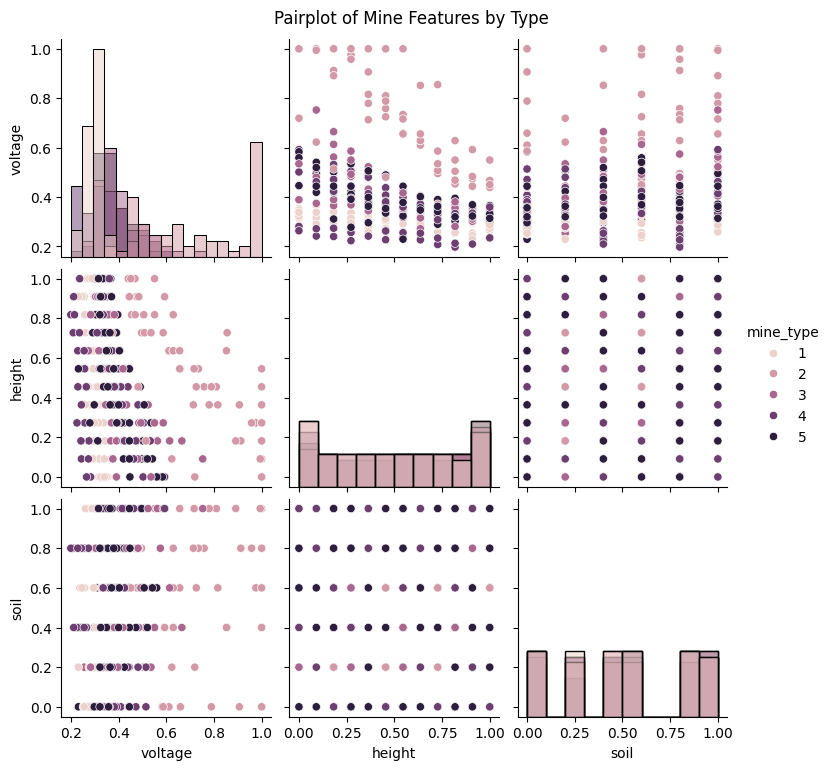

In [38]:
mines_df = pd.read_csv('./data/land_mines.csv')

print("--- Data Head ---")
print(mines_df.head())

print("\n--- Data Info ---")
print(mines_df.info())

print("\n--- Target Variable Distribution (mine_type) ---")
print(mines_df['mine_type'].value_counts().sort_index())

print("\n--- Feature Summary Statistics ---")
print(mines_df[['voltage', 'height', 'soil']].describe())

# Visual EDA: Pairplot colored by mine_type
sns.pairplot(mines_df, hue='mine_type', diag_kind='hist')
plt.suptitle('Pairplot of Mine Features by Type', y=1.02)
plt.show()

In [39]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = mines_df[['voltage', 'height', 'soil']]
y = mines_df['mine_type']

# Split the data 50/50, stratifying by y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=100, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 169
Test set size: 169


The optimal k is: 3 with a test accuracy of 0.4320


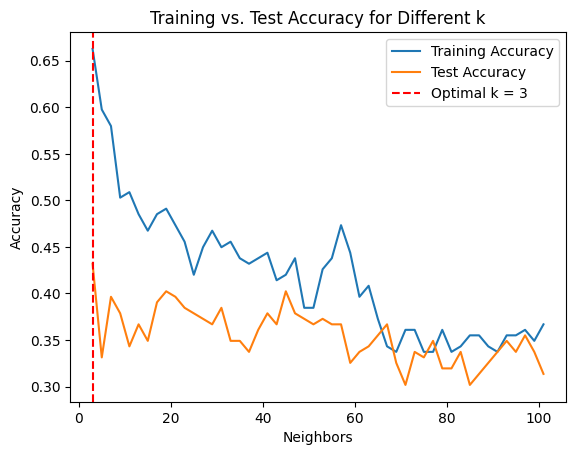

In [40]:
from sklearn.neighbors import KNeighborsClassifier

# Define a grid of odd k values (as shown in the slide)
k_grid = np.array([(2*k + 3) for k in range(0, 50)])

test_accuracies = []
train_accuracies = []

for k in k_grid:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)

    # Compute accuracies
    test_acc = model.score(X_test, y_test)
    train_acc = model.score(X_train, y_train)

    test_accuracies.append(test_acc)
    train_accuracies.append(train_acc)

# Find the optimal k (the one with the highest test accuracy)
optimal_index = np.argmax(test_accuracies)
k_optimal = k_grid[optimal_index]
optimal_test_accuracy = test_accuracies[optimal_index]

print(f"The optimal k is: {k_optimal} with a test accuracy of {optimal_test_accuracy:.4f}")

# Plot the results (mimicking the slide's plot)
sns.lineplot(x=k_grid, y=train_accuracies, label='Training Accuracy').set(xlabel='Neighbors', ylabel='Accuracy')
sns.lineplot(x=k_grid, y=test_accuracies, label='Test Accuracy')
plt.title('Training vs. Test Accuracy for Different k')
plt.axvline(x=k_optimal, color='red', linestyle='--', label=f'Optimal k = {k_optimal}')
plt.legend()
plt.show()

In [41]:
# Train the best model
best_model = KNeighborsClassifier(n_neighbors=k_optimal)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Print confusion matrix using pd.crosstab
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix for Best Model:")
print(confusion_matrix)

# Print test accuracy
final_accuracy = best_model.score(X_test, y_test)
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")


Confusion Matrix for Best Model:
Predicted   1   2   3  4  5
Actual                     
1          24   0   6  3  3
2           1  29   2  2  1
3          15   3   8  1  6
4          10   4  10  8  1
5          14   1  12  1  4

Final Test Accuracy: 0.4320


**Q3.** This question is a case study for $k$ nearest neighbor regression, using the `USA_cars_datasets.csv` data.

The target variable `y` is `price` and the features are `year` and `mileage`.

1. Load the `./data/USA_cars_datasets.csv`. Keep the following variables and drop the rest: `price`, `year`, `mileage`. Are there any `NA`'s to handle? Look at the head and dimensions of the data.
2. Maxmin normalize `year` and `mileage`.
3. Split the sample into ~80% for training and ~20% for hyper-parameter selection and evaluation.
4. Use the $k$-NN algorithm and the training data to predict `price` using `year` and `mileage` for the test set for $k=3,10,25,50,100,300$. For each value of $k$, compute the mean squared error and print a scatterplot showing the test value plotted against the predicted value. What patterns do you notice as you increase $k$?
5. Determine the optimal $k$ for these data.
6. Describe what happened in the plots of predicted versus actual prices as $k$ varied, taking your answer into part 6 into account. (Hint: Use the words "underfitting" and "overfitting".)

In [42]:
cars_df = pd.read_csv('./data/USA_cars_datasets.csv')

# Keep only the specified columns
cars_df = cars_df[['price', 'year', 'mileage']].copy()

# Check for and handle NA's
print(f"Initial shape: {cars_df.shape}")
print(f"Number of NA values:\n{cars_df.isna().sum()}")
# If there were NA's, we would drop them or impute. For this dataset, there likely are none.
cars_df = cars_df.dropna()

print(f"Shape after dropping NA: {cars_df.shape}")
print("\n--- Data Head ---")
print(cars_df.head())

Initial shape: (2499, 3)
Number of NA values:
price      0
year       0
mileage    0
dtype: int64
Shape after dropping NA: (2499, 3)

--- Data Head ---
   price  year  mileage
0   6300  2008   274117
1   2899  2011   190552
2   5350  2018    39590
3  25000  2014    64146
4  27700  2018     6654


In [43]:
def maxmin_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Apply normalization to the feature columns
cars_df['year_norm'] = maxmin_normalize(cars_df['year'])
cars_df['mileage_norm'] = maxmin_normalize(cars_df['mileage'])

print("\n--- Normalized Feature Summary ---")
print(cars_df[['year_norm', 'mileage_norm']].describe())


--- Normalized Feature Summary ---
         year_norm  mileage_norm
count  2499.000000   2499.000000
mean      0.930091      0.051377
std       0.073248      0.058654
min       0.000000      0.000000
25%       0.914894      0.021088
50%       0.957447      0.034742
75%       0.978723      0.062354
max       1.000000      1.000000


In [44]:
from sklearn.model_selection import train_test_split

X = cars_df[['year_norm', 'mileage_norm']]
y = cars_df['price']

# Assuming X is your normalized features ['year_norm', 'mileage_norm'] and y is 'price'
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1999
Test set size: 500


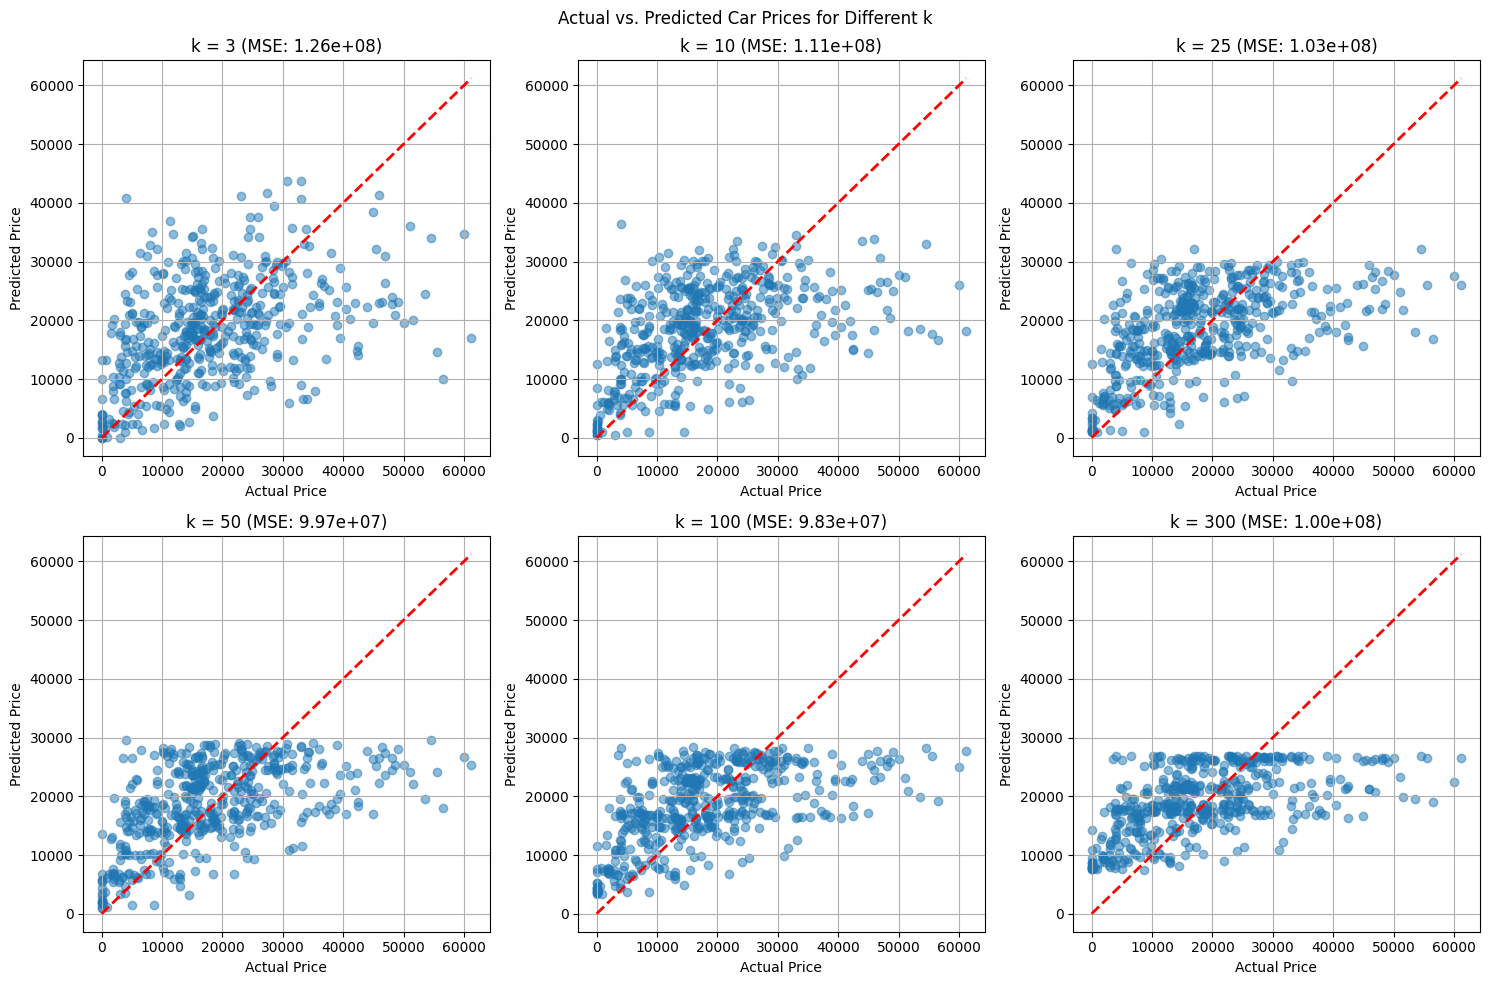

k=3: MSE = 1.26e+08
k=10: MSE = 1.11e+08
k=25: MSE = 1.03e+08
k=50: MSE = 9.97e+07
k=100: MSE = 9.83e+07
k=300: MSE = 1.00e+08


In [45]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Define the grid of k values from the question
k_list = [3, 10, 25, 50, 100, 300]
results = {}

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, k in enumerate(k_list):
    # Create and fit the model
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    results[k] = {'model': model, 'predictions': y_pred, 'mse': mse}

    # Create scatter plot
    axes[i].scatter(y_test, y_pred, alpha=0.5)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual Price')
    axes[i].set_ylabel('Predicted Price')
    axes[i].set_title(f'k = {k} (MSE: {mse:.2e})')
    axes[i].grid(True)

plt.suptitle('Actual vs. Predicted Car Prices for Different k')
plt.tight_layout()
plt.show()

# Print MSEs
for k, res in results.items():
    print(f"k={k}: MSE = {res['mse']:.2e}")

In [46]:
# Find the k with the minimum MSE
optimal_k = min(results, key=lambda k: results[k]['mse'])
optimal_mse = results[optimal_k]['mse']
print(f"\nThe optimal k is: {optimal_k} with an MSE of {optimal_mse:.2e}")


The optimal k is: 100 with an MSE of 9.83e+07


**Q4.** This question is a case study for $k$ nearest neighbor regression, using the `heart_failure_clinical_records_dataset.csv` data.

The data for the question include:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- death event: if the patient deceased during the follow-up period (boolean)

1. Load the `./data/heart_failure_clinical_records_dataset.csv`. Are there any `NA`'s to handle? use `.drop()` to remove `time` from the dataframe.
2. Make a correlation matrix. What variables are strongly associated with a death event?
3. For the dummy variables `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, and `smoking`, compute a summary table of `DEATH_EVENT` grouped by the variable. For which variables does a higher proportion of the population die when the variable takes the value 1 rather than 0?
4. On the basis of your answers from 2 and 3, build a matrix $X$ of the variables you think are most predictive of a death, and a variable $y$ equal to `DEATH_EVENT`.
5. Maxmin normalize all of the variables in `X`.
6. Split the sample into ~80% for training and ~20% for evaluation. (Try to use the same train/test split for the whole question, so that you're comparing apples to apples in the questions below.).
7. Determine the optimal number of neighbors for a $k$-NN classification or regression for the variables you selected.
8. OK, do steps 5 through 7 again, but use all of the variables (except `time`). Which model has the best Mean Squared Error? Which would you prefer to use in practice, if you had to predict `DEATH_EVENT`s? If you play with the selection of variables, how much does the RMSE change for your fitted model on the test data? Are more variables always better? Explain your findings.

In [47]:
heart_df = pd.read_csv('./data/heart_failure_clinical_records_dataset.csv')

print(f"Initial shape: {heart_df.shape}")
print(f"Number of NA values:\n{heart_df.isna().sum()}")
# Drop the 'time' column as instructed
heart_df = heart_df.drop('time', axis=1)
print(f"Shape after dropping 'time': {heart_df.shape}")

Initial shape: (299, 13)
Number of NA values:
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64
Shape after dropping 'time': (299, 12)


In [48]:
# Calculate correlation matrix
corr_matrix = heart_df.corr()

# Show variables most correlated with DEATH_EVENT
death_corr = corr_matrix['DEATH_EVENT'].sort_values(ascending=False)
print("Variables most strongly associated with DEATH_EVENT:")
print(death_corr)

Variables most strongly associated with DEATH_EVENT:
DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
Name: DEATH_EVENT, dtype: float64


In [49]:
dummy_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

for var in dummy_vars:
    print(f"\n--- DEATH_EVENT proportion by {var} ---")
    # Group by the dummy variable and calculate the mean of DEATH_EVENT (which gives the proportion)
    proportion_table = heart_df.groupby(var)['DEATH_EVENT'].mean()
    print(proportion_table)

    # Determine if a higher proportion dies when the variable is 1
    if 1 in proportion_table.index and 0 in proportion_table.index:
        if proportion_table[1] > proportion_table[0]:
            print(f"Higher proportion of death when {var} = 1.")
        else:
            print(f"Higher proportion of death when {var} = 0.")


--- DEATH_EVENT proportion by anaemia ---
anaemia
0    0.294118
1    0.356589
Name: DEATH_EVENT, dtype: float64
Higher proportion of death when anaemia = 1.

--- DEATH_EVENT proportion by diabetes ---
diabetes
0    0.321839
1    0.320000
Name: DEATH_EVENT, dtype: float64
Higher proportion of death when diabetes = 0.

--- DEATH_EVENT proportion by high_blood_pressure ---
high_blood_pressure
0    0.293814
1    0.371429
Name: DEATH_EVENT, dtype: float64
Higher proportion of death when high_blood_pressure = 1.

--- DEATH_EVENT proportion by sex ---
sex
0    0.323810
1    0.319588
Name: DEATH_EVENT, dtype: float64
Higher proportion of death when sex = 0.

--- DEATH_EVENT proportion by smoking ---
smoking
0    0.325123
1    0.312500
Name: DEATH_EVENT, dtype: float64
Higher proportion of death when smoking = 0.


In [51]:
# Model 1: Selected subset based on correlation strength
selected_features = ['serum_creatinine', 'age', 'ejection_fraction',
                     'serum_sodium', 'high_blood_pressure']
X_subset = heart_df[selected_features].copy()
y = heart_df['DEATH_EVENT']

print(f"Selected features: {selected_features}")
print(f"Feature matrix shape: {X_subset.shape}")

Selected features: ['serum_creatinine', 'age', 'ejection_fraction', 'serum_sodium', 'high_blood_pressure']
Feature matrix shape: (299, 5)


In [52]:
def maxmin_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Create normalized version
X_subset_norm = pd.DataFrame()
for col in X_subset.columns:
    X_subset_norm[col + '_norm'] = maxmin_normalize(X_subset[col])

print("\nNormalized feature summary:")
print(X_subset_norm.describe())


Normalized feature summary:
       serum_creatinine_norm    age_norm  ejection_fraction_norm  \
count             299.000000  299.000000              299.000000   
mean                0.100436    0.378798                0.364903   
std                 0.116237    0.216269                0.179316   
min                 0.000000    0.000000                0.000000   
25%                 0.044944    0.200000                0.242424   
50%                 0.067416    0.363636                0.363636   
75%                 0.101124    0.545455                0.469697   
max                 1.000000    1.000000                1.000000   

       serum_sodium_norm  high_blood_pressure_norm  
count         299.000000                299.000000  
mean            0.675012                  0.351171  
std             0.126071                  0.478136  
min             0.000000                  0.000000  
25%             0.600000                  0.000000  
50%             0.685714                

In [53]:
# Split the data
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_subset_norm, y, test_size=0.2, random_state=100, stratify=y
)

print(f"Training set size: {len(X_train_s)}")
print(f"Test set size: {len(X_test_s)}")
print(f"Training set death event distribution:\n{y_train_s.value_counts()}")
print(f"Test set death event distribution:\n{y_test_s.value_counts()}")

Training set size: 239
Test set size: 60
Training set death event distribution:
DEATH_EVENT
0    162
1     77
Name: count, dtype: int64
Test set death event distribution:
DEATH_EVENT
0    41
1    19
Name: count, dtype: int64


Testing different k values...

Optimal k for subset model: 21
Test accuracy at optimal k: 0.7667


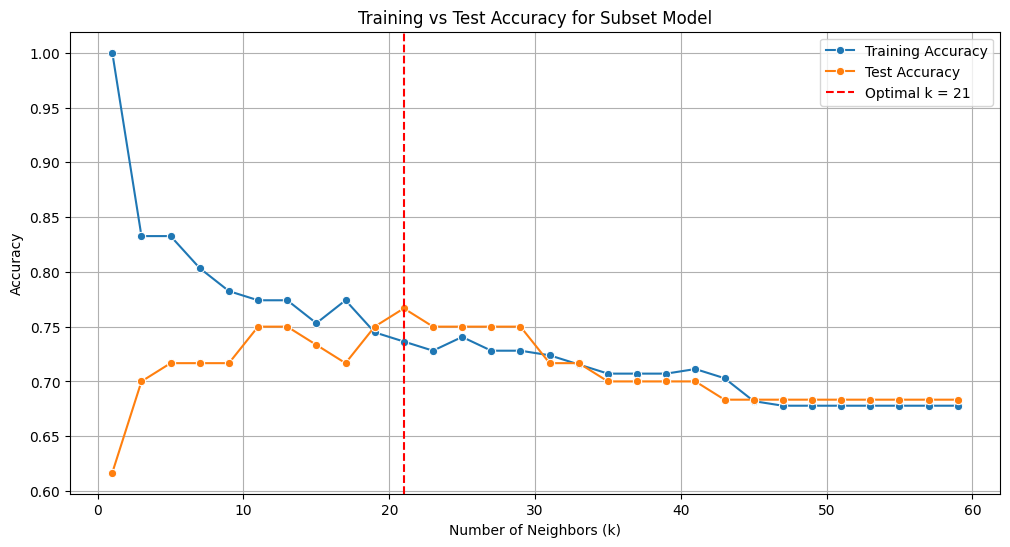

In [54]:
# Grid of odd k values (following the slide method)
k_grid = np.array([(2*k + 1) for k in range(0, 30)])  # Odd numbers: 1, 3, 5, ..., 59

test_accuracies = []
train_accuracies = []

print("Testing different k values...")
for k in k_grid:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_s, y_train_s)

    test_acc = model.score(X_test_s, y_test_s)
    train_acc = model.score(X_train_s, y_train_s)

    test_accuracies.append(test_acc)
    train_accuracies.append(train_acc)

# Find optimal k
optimal_idx = np.argmax(test_accuracies)
k_optimal_subset = k_grid[optimal_idx]
optimal_test_acc = test_accuracies[optimal_idx]

print(f"\nOptimal k for subset model: {k_optimal_subset}")
print(f"Test accuracy at optimal k: {optimal_test_acc:.4f}")

# Plot training vs test accuracy
plt.figure(figsize=(12, 6))
sns.lineplot(x=k_grid, y=train_accuracies, label='Training Accuracy', marker='o')
sns.lineplot(x=k_grid, y=test_accuracies, label='Test Accuracy', marker='o')
plt.axvline(x=k_optimal_subset, color='red', linestyle='--',
            label=f'Optimal k = {k_optimal_subset}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy for Subset Model')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Model 2: All features
all_features = [col for col in heart_df.columns if col != 'DEATH_EVENT']
X_all = heart_df[all_features].copy()

# Normalize all features
X_all_norm = pd.DataFrame()
for col in X_all.columns:
    X_all_norm[col + '_norm'] = maxmin_normalize(X_all[col])

# Split (same random_state for fair comparison)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_all_norm, y, test_size=0.2, random_state=100, stratify=y
)

# Find optimal k for all-features model
test_accuracies_all = []
train_accuracies_all = []

for k in k_grid:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_a, y_train_a)

    test_acc = model.score(X_test_a, y_test_a)
    train_acc = model.score(X_train_a, y_train_a)

    test_accuracies_all.append(test_acc)
    train_accuracies_all.append(train_acc)

optimal_idx_all = np.argmax(test_accuracies_all)
k_optimal_all = k_grid[optimal_idx_all]
optimal_test_acc_all = test_accuracies_all[optimal_idx_all]

print(f"\nOptimal k for all-features model: {k_optimal_all}")
print(f"Test accuracy at optimal k: {optimal_test_acc_all:.4f}")


Optimal k for all-features model: 11
Test accuracy at optimal k: 0.7167


**Q5.** This is a case study on $k$ nearest neighbor classification, using the `animals.csv` data.

The data consist of a label, `class`, taking integer values 1 to 7, the name of the species, `animal`, and 16 characteristics of the animal, including `hair`, `feathers`, `milk`, `eggs`, `airborne`, and so on.

1. Load the data. For each of the seven class labels, print the values in the class and get a sense of what is included in that group. Perform some other EDA: How big are the classes? How much variation is there in each of the features/covariates? Which variables do you think will best predict which class?
2. Split the data 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be. Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Using all of the variables, build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion matrix for the optimal model, comparing predicted and actual class label on the test set. How accurate it is? Can you interpret why mistakes are made across groups?
5. Use only `milk`, `aquatic`, and `airborne` to train a new $k$-NN classifier. Print your confusion table. Mine does not predict all of the classes, only a subset of them. To see the underlying proportions/probabilities, use `model.predict_proba(X_test.values)` to predict probabilities rather than labels for your `X_test` test data for your fitted `model`. Are all of the classes represented? Explain your results.

**Q6.** This is a case study using $k$ nearest neighbor regression for imputation, using the `airbnb_hw.csv` data.

There are 30,478 observations, but only 22,155 ratings. We're going to build a kNN regressor to impute missing values. This is a common task, and illustrates one way you can use kNN in the future even when you have more advanced models available.

1. Load the `airbnb_hw.csv` data with Pandas. We're only going to use `Review Scores Rating`, `Price`, and `Beds`, so use `.loc` to column filter the dataframe to those variables.
2. Set use `.isnull()` and `.loc` to select the subset of the dataframe with missing review values. Set those aside in a different dataframe. We'll make predictions about them later.
3. Use `df = df.dropna(axis = 0, how = 'any')` to eliminate any observations with missing values/NA's from the dataframe.
4. For the complete cases, create a $k$-NN model that uses the variables `Price` and `Beds` to predict `Review Scores Rating`. How do you choose $k$? (Hint: Train/test split, iterate over reasonable values of $k$ and find a value that minimizes SSE on the test split using predictions from the training set.)
5. Predict the missing ratings.
6. Do a kernel density plot of the training ratings and the predicted missing ratings. Do they look similar or not? Describe what you see.

**Q7.** Let's do some very basic computer vision. We're going to import the MNIST handwritten digits data and use $k$-NN to predict values (i.e. "see/read").

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a list of matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use the reshaped `X_test` and `y_test` data to create a $k$-nearest neighbor classifier of digit. What is the optimal number of neighbors $k$? If you can't determine this, play around with different values of $k$ for your classifier.
5. For the optimal number of neighbors, how well does your predictor perform on the test set? Report the accuracy, compute a confusion matrix, and explain your findings.
6. For your confusion matrix, which mistakes are most likely? Do you find any interesting patterns?
7. So, this is how computers "see." They convert an image into a matrix of values, that matrix becomes a vector in a dataset, and then we deploy ML tools on it as if it was any other kind of tabular data. To make sure you follow this, invent a way to represent a color photo in matrix form, and then describe how you could convert it into tabular data. (Hint: RGB color codes provide a method of encoding a numeric value that represents a color.)